# Determining the Best Classification Model for Loan Default Prediction

by **Young Hun Ji**

May 21, 2021

!["auto1"](cover.jpg "cover")

## Abstract

In this project, I trained a classification model for predicting loan status (i.e., paid off versus in collection). The dataset consists of data on ***N*** = 500 loans and was obtained from *Kaggle* via the following link: [Loan Data](https://www.kaggle.com/zhijinzhai/loandata).

After an initial exploration of the dataset, **five features** were selected for model development. Subsequently, the dataset was split into training (80%) and testing (20%) sets.

Using the training dataset, classification model instances were built using the following algorithms:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression
-   XGBoost

All hyperparameters were tuned using **5-fold cross validation** and **Bayesian optimization** (in the case of XGBoost classification). Based on a comparison of the models' mean CV scores (specifically the weighted F1 scores), an XGBoost classification model was determined to be optimal (F1 score = 0.75, Jaccard index = 0.65, log loss = 0.47).

Evaluation of the final model using the testing dataset yielded the following metrics: **F1 score = 0.74, Jaccard index = 0.64, log loss = 0.45**. Limitations and future directions are discussed.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#chapter1">About the Dataset</a><br><br>
2.  <a href="#chapter2">Data Visualization and Preprocessing</a><br>
     * 2.1 <a href="#chapter2.1">Loading and Inspecting the Dataset</a><br>
     * 2.2 <a href="#chapter2.2">Stacked Histograms</a><br>
     * 2.3 <a href="#chapter2.3">Categorical to Numerical Conversion</a><br>
     * 2.4 <a href="#chapter2.4">One Hot Encoding</a><br>
     * 2.5 <a href="#chapter2.5">Feature Scaling and Data Splitting</a><br><br>
3.  <a href="#chapter3">Model Development and Hyperparameter-Tuning</a><br>
     * 3.1 <a href="#chapter3.1">K-Nearest Neighbors</a><br>
     * 3.2 <a href="#chapter3.2">Decision Tree</a><br>
     * 3.3 <a href="#chapter3.3">Support Vector Machine</a><br>
     * 3.4 <a href="#chapter3.4">Logistic Regression</a><br>
     * 3.5 <a href="#chapter3.5">XGBoost Classifier</a><br>
     * 3.6 <a href="#chapter3.6">Summary of Evaluation Metrics Using the Training Data</a><br><br>
4.  <a href="#chapter4">Final Model Evaluation</a><br>
     * 4.1 <a href="#chapter4.1">Evaluation Metrics Using the Testing Data</a><br>
     * 4.2 <a href="#chapter4.2">Classification Report and Confusion Matrix</a><br>
     * 4.3 <a href="#chapter4.3">Limitations and Future Directions</a>
    </font>
    </div>

## 1. About the Dataset <a class="anchor" id="chapter1"></a>

The present dataset was obtained from *Kaggle* via the following link: [Loan Data](https://www.kaggle.com/zhijinzhai/loandata).

The dataset is titled **"Loan payments data.csv"** and includes details of 500 customers whose loans have been either paid or sent to collections. Specifically, it includes the following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_ID        | Unique identifier                                                                     |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the origination                                        |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Paidoff_time   | The time a customer paid off the loan (if at all)                                     |
| Pastdue_days   | How many days, if any, a loan has been past due                                       |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


## 2. Data Visualization and Preprocessing <a class="anchor" id="chapter2"></a>

Prior to loading the dataset, I imported all dependencies required for the analysis:

In [1]:
import itertools
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, log_loss, jaccard_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
%matplotlib inline
seed = 500

### 2.1 Loading and Inspecting the Dataset<a class="anchor" id="chapter2.1"></a>

After downloading the dataset from *Kaggle* (Link to dataset: [Loan Data](https://www.kaggle.com/zhijinzhai/loandata)), I loaded the csv file as follows:

In [2]:
df = pd.read_csv('Loan payments data.csv')

# Viewing the first 5 rows
df.head()

,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female


Checking the shape:

In [3]:
df.shape

(500, 11)

Before proceeding, I dropped the columns `Loan_ID`, `paid_off_time`, and `past_due_days`, as they will not be used for this analysis:

In [4]:
df.drop('Loan_ID', axis=1, inplace = True)
df.drop('paid_off_time', axis=1, inplace = True)
df.drop('past_due_days', axis=1, inplace = True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female


Checking if there are missing values—there are none: 

In [5]:
df.isnull().sum()

loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

Next, I converted the columns `due_date` and `effective_date` to date time objects:

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female


Checking how many of each class exists in the dataset:

In [7]:
df['loan_status'].value_counts()

PAIDOFF               300
COLLECTION_PAIDOFF    100
COLLECTION            100
Name: loan_status, dtype: int64

So there were three classes: (1) paid off, (2) sent to collections, and (3) paid off after being sent to collections. 

In this particular analysis, I grouped 1 and 3 together (i.e., resulting in a new class representing people that pay off their loans, either with or without collection efforts):

In [8]:
# Re-coding values from "collection_paidoff" to "paidoff"
df['loan_status']= df['loan_status'].map({'PAIDOFF': 'PAIDOFF', 'COLLECTION': 'COLLECTION', 'COLLECTION_PAIDOFF': 'PAIDOFF'})

As shown below, recoding made `loan_status` a binary variable with the 400 values in "paid off" and 100 in "collection":

In [9]:
df['loan_status'].value_counts()

PAIDOFF       400
COLLECTION    100
Name: loan_status, dtype: int64

### 2.2 Stacked Histograms <a class="anchor" id="chapter2.2"></a>

I plotted some histograms to understand the data bettter:

In [10]:
# Setting the seaborn theme to "darkgrid"
sns.set_style("darkgrid")

First, I plotted the distribution of principal amount by loan status and gender:

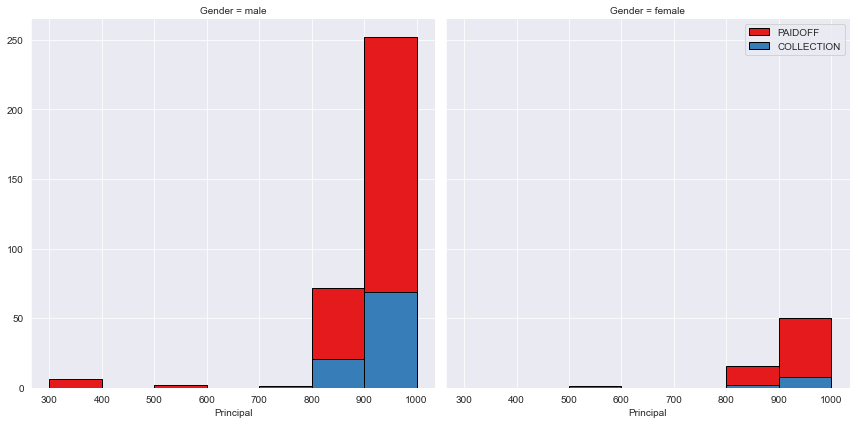

In [11]:
# Plotting the distribution of principal amount by loan status and gender
bins = np.linspace(df.Principal.min(), df.Principal.max(), 8)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2, height=6, aspect=1)
g.map(plt.hist, 'Principal', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Based on the histograms, it appeared that loans were more likely to be in collection when the principal amount was high and when the borrower was male.

Checking loan status counts by gender showed that approximately 87% of females paid off their loans versus 79% of males:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.870130
        COLLECTION     0.129870
male    PAIDOFF        0.787234
        COLLECTION     0.212766
Name: loan_status, dtype: float64

Second, I plotted the distribution of age by loan status and gender:

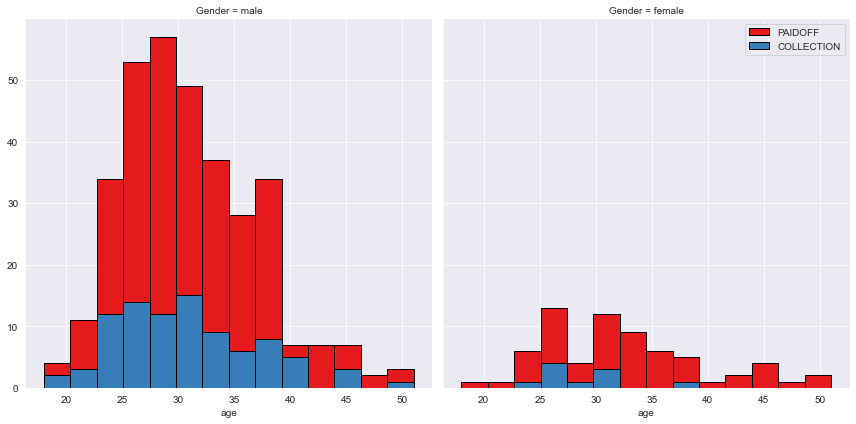

In [13]:
# Plotting the distribution of age by loan status and gender
bins = np.linspace(df.age.min(), df.age.max(), 15)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2, height=6, aspect=1)
g.map(plt.hist, 'age', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Based on the histograms, it appeared that loans were more likely to be in collection when the borrower was young (e.g., 35 or below).

Third, I wanted to check whether the day of the week in which the loan was originated (e.g., effective date was Monday versus Friday) has an impact on loan status. So I created a new variable `daysofweek` representing the day of the week, then plotted the distribution of days by loan status and gender:

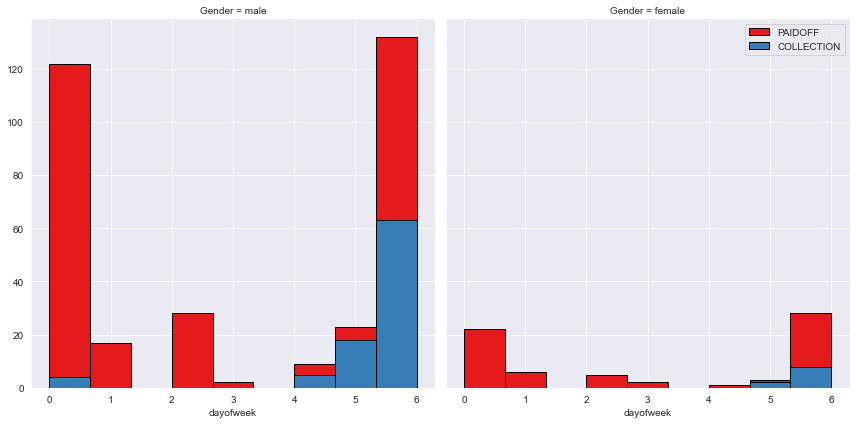

In [14]:
# Creating a new column representing the day of the week in which the loan took effect
df['dayofweek'] = df['effective_date'].dt.dayofweek

# Plotting the distribution of days by loan status and gender:
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2, height=6, aspect=1)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k", )
g.axes[-1].legend()
plt.show()

Based on the histograms, it appeared that loans were more likely to be in collections if it originated near the end of the week 

As such, I dichotomized the variable with day 4 as the threshold. Specifically, I created a new, binary variable named `weekend` where days 4 to 6 (i.e., Friday through Sunday) were coded as 1, and days 0 through 3 (i.e., Monday through Thursday) were coded as 0:

In [15]:
# Creating a new binary column representing whether or not the loan originated near the end of the week
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1


### 2.3 Categorical to Numerical Conversion <a class="anchor" id="chapter2.3"></a>

Next, I converted the categorical column `Gender` into a numerical one (0 = "male", 1 = "female"):

In [16]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1


### 2.4 One Hot Encoding <a class="anchor" id="chapter2.4"></a>

Checking value counts for education:

In [17]:
df['education'].value_counts(normalize=False)

college                 220
High School or Below    209
Bechalor                 67
Master or Above           4
Name: education, dtype: int64

Checking loan status counts by education suggested that there are significant differences across education levels:

In [18]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.835821
                      COLLECTION     0.164179
High School or Below  PAIDOFF        0.765550
                      COLLECTION     0.234450
Master or Above       PAIDOFF        0.750000
                      COLLECTION     0.250000
college               PAIDOFF        0.822727
                      COLLECTION     0.177273
Name: loan_status, dtype: float64

I then used one hot encoding to convert the categorical variable `education` into multiple binary variables and appended them to the dataframe. Here, I also decided to remove the education level "Master or above" because it only had 4 observations.

In [19]:
# Defining the feature set
Feature = df[['Principal','terms','age','Gender','weekend']]

# One hot encoding
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)

# Dropping the education level "Master or above"
Feature.drop(['Master or Above'], axis = 1,inplace=True)

# Viewing the first 5 rows
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,50,1,0,1,0,0
2,1000,30,33,1,0,1,0,0
3,1000,15,27,0,0,0,0,1
4,1000,30,28,1,1,0,0,1


### 2.5 Feature Scaling and Data Splitting <a class="anchor" id="chapter2.5"></a>

I decided to scale the features before splitting the data into training and testing sets. Specifically, I used *z-standardization* to standardize all features, i.e., subtracting the mean from each data point and then dividing that number by the standard deviation; z = (x - u) / s using the `StandardScaler` function. This results in each feature having a mean of zero and its variance being the unit of measurement.

First, defining `x` as the feature set:

In [20]:
x = Feature
x[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,50,1,0,1,0,0
2,1000,30,33,1,0,1,0,0
3,1000,15,27,0,0,0,0,1
4,1000,30,28,1,1,0,0,1


Second, defining `y` as the loan status values:

In [21]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

Third, using *z-standardization* on the features:

In [22]:
x = preprocessing.StandardScaler().fit(x).transform(x)
x[0:5]

array([[ 0.49337687,  0.89789115,  2.28404253, -0.42665337, -1.18484014,
        -0.39336295,  1.17997648, -0.88640526],
       [ 0.49337687,  0.89789115,  3.10658738,  2.34382305, -1.18484014,
         2.54218146, -0.84747452, -0.88640526],
       [ 0.49337687,  0.89789115,  0.3099349 ,  2.34382305, -1.18484014,
         2.54218146, -0.84747452, -0.88640526],
       [ 0.49337687, -0.97897162, -0.67711892, -0.42665337, -1.18484014,
        -0.39336295, -0.84747452,  1.12815215],
       [ 0.49337687,  0.89789115, -0.51260995,  2.34382305,  0.84399572,
        -0.39336295, -0.84747452,  1.12815215]])

Finally, after scaling the features, I split the data into training (80%) and testing (20%) datasets:

In [23]:
# Splitting data into training (80%) and testing (20%) sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=seed)

# Inspecting shapes
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (400, 8) (400,)
Test set: (100, 8) (100,)


## 3. Model Development and Hyperparameter-Tuning <a class="anchor" id="chapter3"></a>

I tested a series of classification models using the following algorithms:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression
-   XGBoost

I tuned all hyperparameters using **_k_-fold cross validation**. This process splits the training dataset further into *k* equal-sized subsamples or *folds*, and then uses *k*-1 folds to train the model and the remaining fold (i.e., the "validation set") to evaluate the model. The process is then repeated sequentially for each combination of folds until each of the *k* folds have been used once as the validation set. I used **5 folds** in this analysis, and I chose hyperparameters that maximized the mean **weighted F1 score** (harmonic mean of precision and recall) across folds.  

The figure below depicts the 5-fold cross validation process. 

!["auto1"](cross_validation_process.png "cross validation process")

### 3.1 K-Nearest Neighbors <a class="anchor" id="chapter3.1"></a>

First, I created a classification model using the *k*-nearest neighbors algorithm.

I chose the optimal number of neighbors *k* by comparing the mean **weighted F1 score** (i.e., harmonic mean of *precision* and *recall*) across the 5 folds for different values of *k* ranging from 1 to 9—this is the range I deemed appropriate for this particular analysis. 

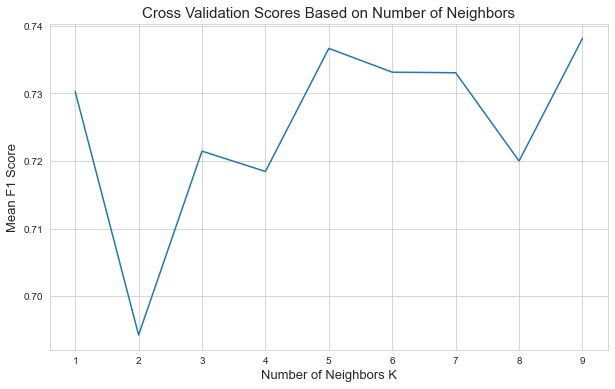

In [24]:
# Defining the range of k
k_range = range(1, 10)
k_scores = []

# Computing the mean F1 score across folds for different values of k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='f1_weighted').mean()
    k_scores.append(scores)
    
# Plotting the F1 scores
sns.set_style("whitegrid")
plt.figure(figsize = (10, 6))
plt.plot(k_range, k_scores)
plt.title("Cross Validation Scores Based on Number of Neighbors", fontsize = 15)
plt.xlabel('Number of Neighbors K', fontsize = 13)
plt.ylabel('Mean F1 Score', fontsize = 13)
plt.show()

So **_k_ = 9** yielded the highest F1 score.

Next, I trained the model with *k* = 9 and computed the mean F1 score across folds. 

Additionally, I computed the mean **Jaccard index** across folds. The Jaccard score refers to the size of the intersection divided by the size of the union of two sets, with the two sets being (1) predicted labels and (2) true labels for a given sample.

In [25]:
# Creating a KNN object with k = 9
knn_tuned = KNeighborsClassifier(n_neighbors = 9)

# Training the model
knn_tuned.fit(x_train, y_train)

# Computing the mean F1 score across folds
f1_knn = cross_val_score(knn_tuned, x_train, y_train, cv = 5, scoring='f1_weighted').mean()
print("F1 score =", "%.4f"%f1_knn)

# Computing the mean Jaccard index across folds
jaccard_knn = cross_val_score(knn_tuned, x_train, y_train, cv = 5, scoring='jaccard_weighted').mean()
print("Jaccard index =", "%.4f"%jaccard_knn)

F1 score = 0.7381
Jaccard index = 0.6397


### 3.2 Decision Tree <a class="anchor" id="chapter3.2"></a>

Second, I created a classification model using a decision tree.

I chose the optimal decision tree depth by comparing the mean **weighted F1 score** across the 5 folds for different depth values ranging from 1 to 10. 

Text(0, 0.5, 'Mean F1 Score')

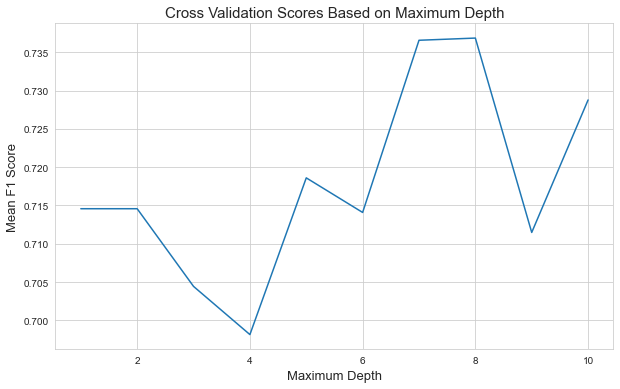

In [26]:
# Defining the maximum depth range:
max_depth_range = list(range(1, 11))

# Computing the mean F1 score across folds for different maximum depths
scores = []
for depth in max_depth_range:
    dt = DecisionTreeClassifier(criterion = "entropy", max_depth = depth, random_state = seed)
    dt.fit(x_train, y_train)    
    score = cross_val_score(dt, x_train, y_train, cv=5, scoring='f1_weighted').mean()
    scores.append(score)
    
# Plotting the F1 scores
plt.figure(figsize = (10, 6))
plt.plot(max_depth_range, scores)
plt.title("Cross Validation Scores Based on Maximum Depth", fontsize = 15)
plt.xlabel("Maximum Depth", fontsize = 13)
plt.ylabel("Mean F1 Score", fontsize = 13)

So a maximum depth of 8 yielded the highest F1 score. 

Next, I trained the model with maximum depth = 8 and computed the mean F1 score and Jaccard index across folds.

In [27]:
# Creating a decision tree object with maximum depth = 8
dt_tuned = DecisionTreeClassifier(criterion = "entropy", max_depth=8, random_state = seed)

# Training the model
dt_tuned.fit(x_train, y_train)    

# Computing the mean F1 score across folds
f1_dt = cross_val_score(dt_tuned, x_train, y_train, cv = 5, scoring='f1_weighted').mean()
print("F1 score =", "%.4f"%f1_dt)

# Computing the mean Jaccard index across folds
jaccard_dt = cross_val_score(dt_tuned, x_train, y_train, cv = 5, scoring='jaccard_weighted').mean()
print("Jaccard index =", "%.4f"%jaccard_dt)

F1 score = 0.7369
Jaccard index = 0.6300


Visualizing the decision tree:

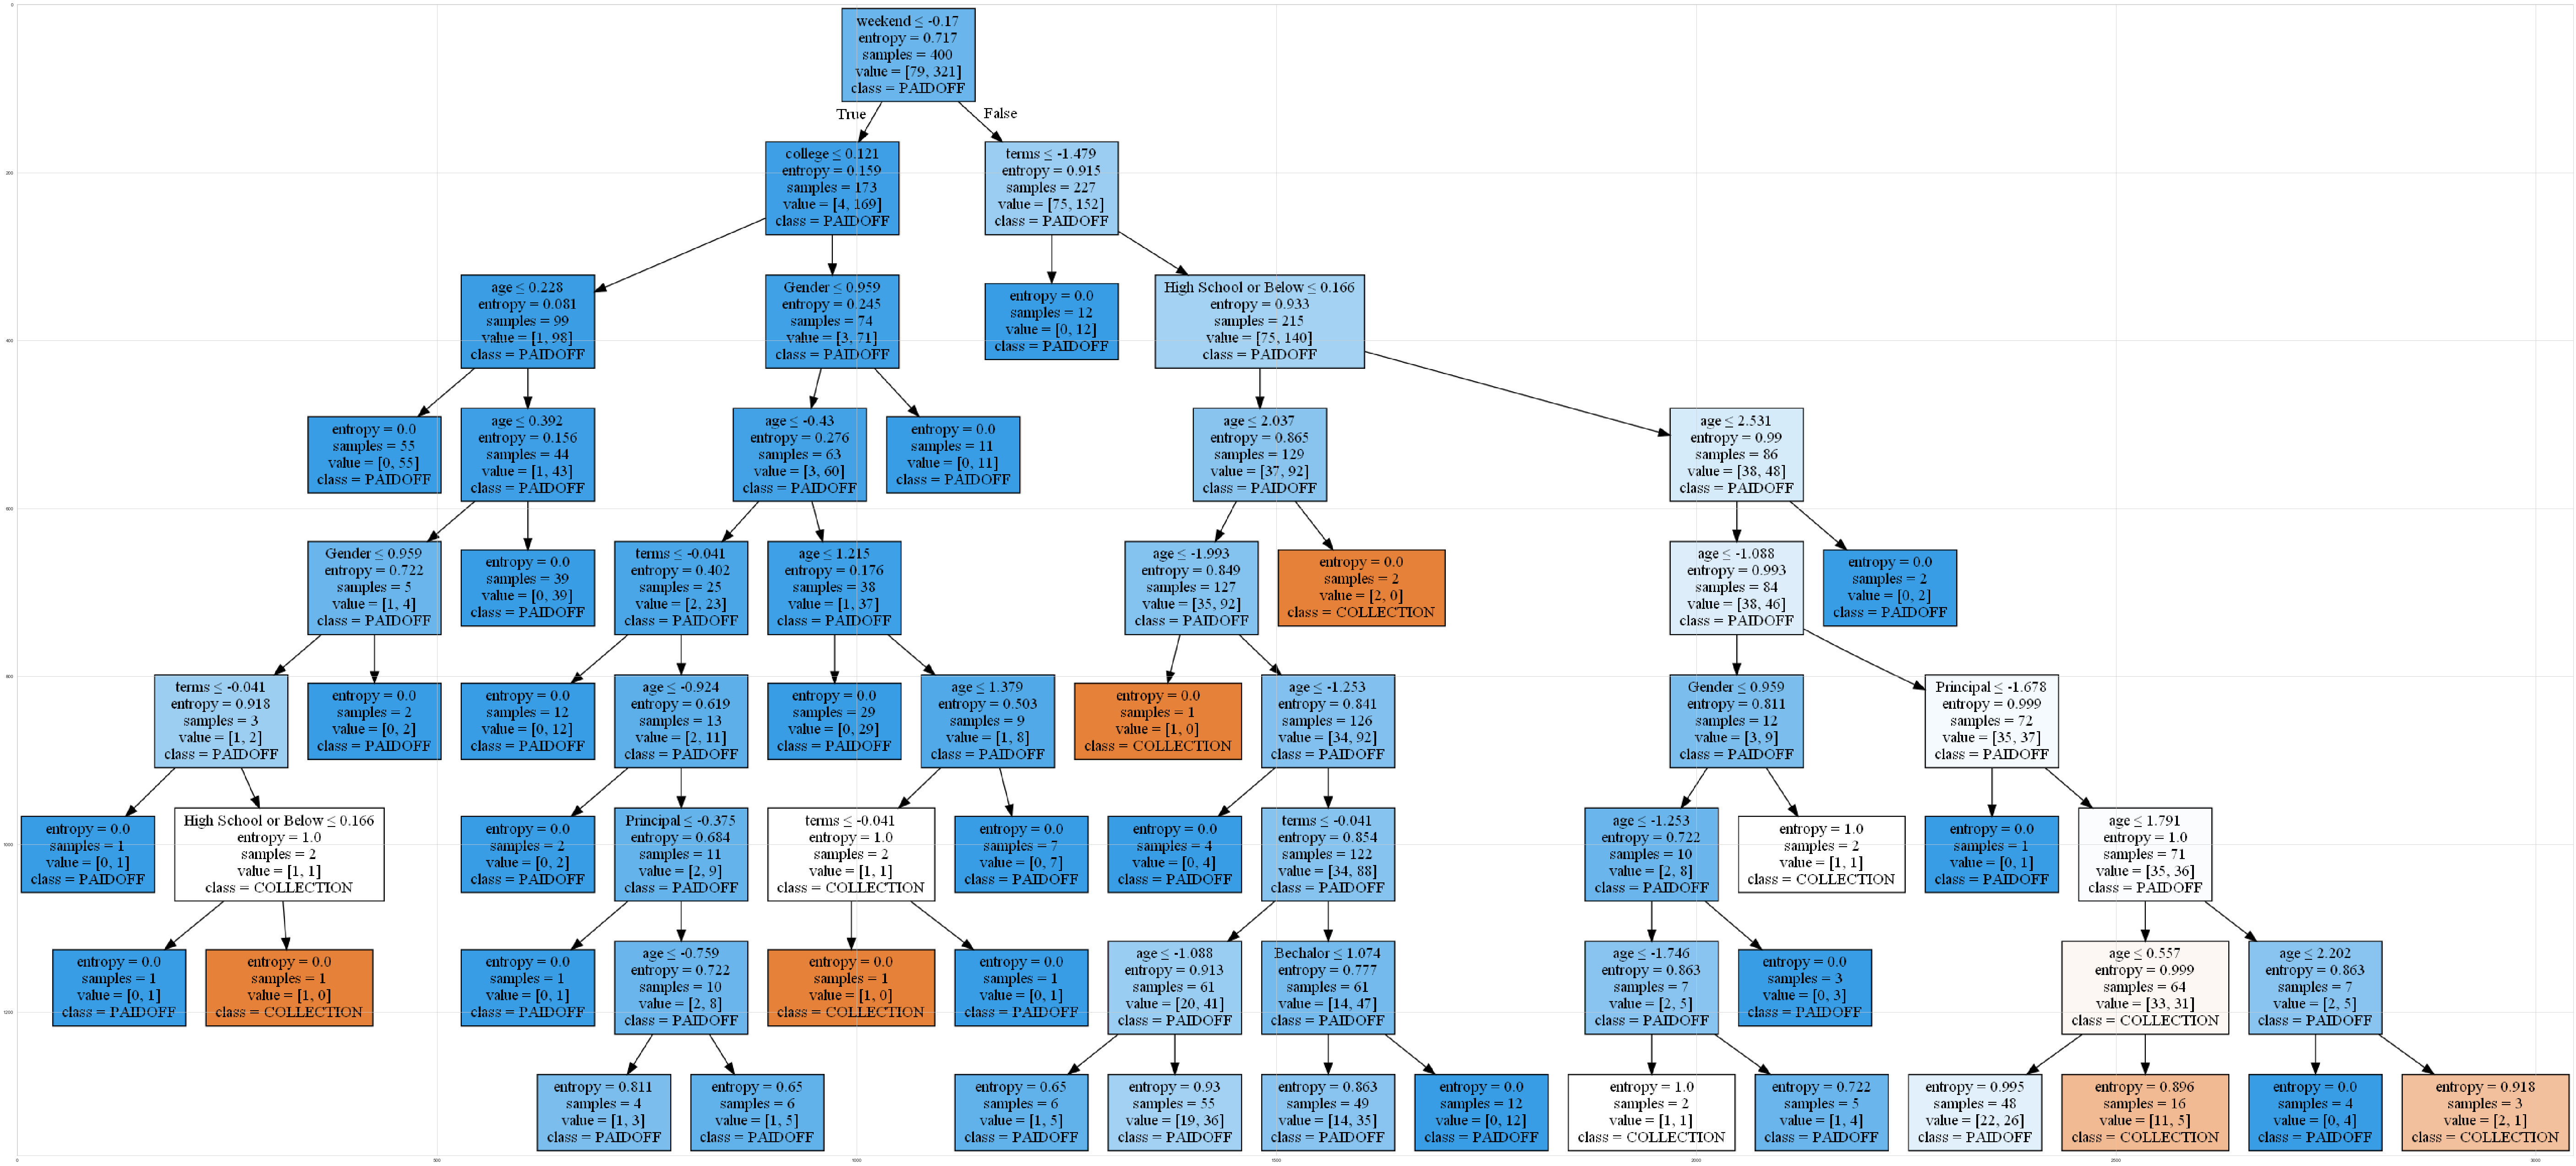

In [28]:
dot_data = StringIO()
filename = "tree.png"
featureNames = Feature.columns
out=tree.export_graphviz(dt_tuned,feature_names=featureNames, 
                         out_file=dot_data, class_names= np.unique(y_train), 
                         filled=True, special_characters=True, rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 100))
plt.imshow(img,interpolation='nearest')

### 3.3 Support Vector Machine <a class="anchor" id="chapter3.3"></a>

Third, I created a classification model using the support vector machine algorithm.

I chose the optimal hyperparameters by comparing the mean **weighted F1 score** across the 5 folds for different regularization values (C) ranging from 0.1 to 100, different gamma values (i.e., scale versus auto), and different kernel types (i.e., linear, rbf, or sigmoid). 

I used `GridSearchCV` to create a grid of parameters and select those that yielded the best cross validated F1 score. 

In [29]:
# Defining the parameter grid
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': ['scale', 'auto'],
              'kernel': ['linear', 'rbf', 'sigmoid']} 

# Creating a support vector machine object
svc = svm.SVC()

# Creating a grid of parameters and cross validation scores
grid = GridSearchCV(svc, param_grid, refit = True, cv = 5, scoring = 'f1_weighted', verbose = 0)
  
# Fitting the model for grid search
grid.fit(x_train, y_train)

# Printing the best parameters
print(grid.best_params_)

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


Next, I trained the model with with the above parameters and computed the mean F1 score and Jaccard index across folds.

In [30]:
# Creating a support vector machine object with the selected parameters
sv_tuned= svm.SVC(C = 10, gamma = 'auto', kernel = 'rbf')

# Training the model
sv_tuned.fit(x_train, y_train)    

# Computing the mean F1 score across folds
f1_sv = cross_val_score(sv_tuned, x_train, y_train, cv = 5, scoring='f1_weighted').mean()
print("F1 score =", "%.4f"%f1_sv)

# Computing the mean Jaccard index across folds
jaccard_sv = cross_val_score(sv_tuned, x_train, y_train, cv = 5, scoring='jaccard_weighted').mean()
print("Jaccard index =", "%.4f"%jaccard_sv)

F1 score = 0.7345
Jaccard index = 0.6400


### 3.4 Logistic Regression <a class="anchor" id="chapter3.4"></a>

Fourth, I created a classifier model using logistic regression. I chose the optimal regularization parameter by comparing the mean weighted F1 score across the 5 folds for different regularization values (C) ranging from 0.05 to 10.

In [31]:
# Defining the parameter grid
param_grid = {'C':np.linspace(0.05, 10, num = 100)} 

# Creating a logistic regressino object
lr = LogisticRegression()

# Creating a grid of parameters and cross validation scores
grid = GridSearchCV(lr, param_grid, refit = True, cv = 5, scoring = 'f1_weighted', verbose = 0)
  
# Fitting the model for grid search
grid.fit(x_train, y_train)

# Printing the best parameters
print(grid.best_params_)

{'C': 0.5525252525252525}


So a regularization parameter of 0.5525 yields the highest cross validated F1 score.<br>
Below is a plot of the F1 scores across different regularization strengths:

Text(0, 0.5, 'Mean F1 Score')

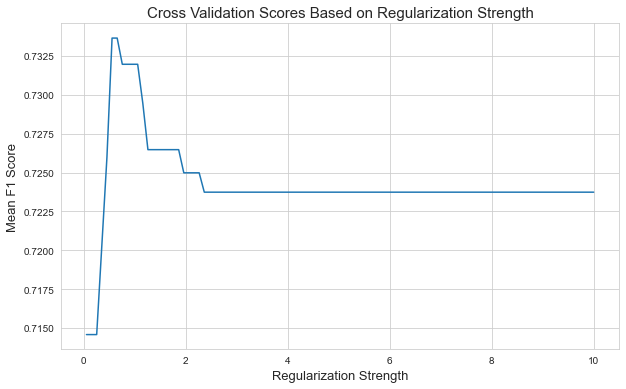

In [32]:
# Defining the range of c values
cvalues= np.linspace(0.05, 10, num = 100)

# Creating a list of F1 scores for different c values
scores = []
for cvalue in cvalues:
    lr = LogisticRegression(C=cvalue).fit(x_train,y_train)
    lr.fit(x_train, y_train)    
    score = cross_val_score(lr, x_train, y_train, cv=5, scoring='f1_weighted').mean()
    scores.append(score)

# Plot the F1 scores
plt.figure(figsize = (10, 6))
plt.plot(cvalues, scores)
plt.title("Cross Validation Scores Based on Regularization Strength", fontsize = 15)
plt.xlabel("Regularization Strength", fontsize = 13)
plt.ylabel("Mean F1 Score", fontsize = 13)

Next, I trained the model using the selected regularization parameter and computed the mean F1 score and Jaccard index across folds.

Additionally, I computed the mean **log loss** across folds. Log loss is a metric used to evaluate classification models whose output is a probability value between 0 and 1.

In [33]:
# Creating a logistic regression model with the selected regularization parameter
lr_tuned = LogisticRegression(C = 0.5525252525252525)

# Training the model
lr_tuned.fit(x_train, y_train)  

# Computing the mean F1 score across folds
f1_lr = cross_val_score(lr_tuned, x_train, y_train, cv = 5, scoring='f1_weighted').mean()
print("F1 score =", "%.4f"%f1_lr)

# Computing the mean Jaccard index across folds
jaccard_lr = cross_val_score(lr_tuned, x_train, y_train, cv = 5, scoring='jaccard_weighted').mean()
print("Jaccard index =", "%.4f"%jaccard_lr)

# Computing the mean log loss across folds
logloss_lr = -1 * cross_val_score(lr_tuned, x_train, y_train, cv = 5, scoring='neg_log_loss').mean()
print("Log loss =", "%.4f"%logloss_lr)

F1 score = 0.7337
Jaccard index = 0.6560
Log loss = 0.4191


### 3.5 XGBoost Classifier<a class="anchor" id="chapter3.5"></a>

Fifth, I created a classifier model using XGBoost, which is an advanced gradient boosting algorithm with numerous advantages, such as regularization, computational efficiency, and high overall effectiveness. 

XGBoost uses numerous "booster parameters", and I selected the following parameters for tuning:

* max_depth
* eta (aka "learning rate")
* gamma
* reg_alpha
* reg_lambda
* subsample
* colsample_bytree
* min_child_weight

Details regarding all XGBoost hyperparameters can be found on the official documentation page: [XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html).

When building an XGBoost classification model, the y labels need to be numerical. As such I created new array `y_train_xgb` which expresses the y values numerically (0 = "paidoff", 1 = "collection").

In [34]:
# Duplicating the y_train dataset
y_train_xgb = y_train

# Coverting the values to numbers
y_train_xgb = np.where(y_train_xgb == 'PAIDOFF', 0, y_train_xgb)
y_train_xgb = np.where(y_train_xgb == 'COLLECTION', 1, y_train_xgb)

# Changing the data type to integer
y_train_xgb = y_train_xgb.astype(int)

# Viewing the array
y_train_xgb

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In order to tune the foregoing parameters, I used **Bayesian optimization** using the `HyperOpt` library. This method uses information from past trials to inform the next set of hyperparameters to explore, making it more efficient, which is especially desirable when handling a large number of parameters.

In [35]:
# Defining the value range for all booster parameters
space={'max_depth': hp.quniform("max_depth", 3, 25, 1),
        'eta': hp.uniform('eta', 0.01, 5),
        'gamma': hp.uniform ('gamma', 0, 5),
        'reg_alpha' : hp.uniform('reg_alpha', 0, 10),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 10),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 1),
        'n_estimators': hp.quniform('n_estimators', 50, 300,1),
        'seed': 100
    }

In [36]:
# Defining the model
def objective(space):
    XGBModel=XGBClassifier(max_depth = int(space['max_depth']),
                          gamma = space['gamma'],
                          eta = space['eta'],
                          reg_alpha = space['reg_alpha'],
                          reg_lambda = space['reg_lambda'],
                          min_child_weight= space['min_child_weight'],
                          colsample_bytree= space['colsample_bytree'],
                          subsample = space['subsample'],
                          eval_metric = 'logloss',
                          use_label_encoder=False,
                          n_estimators = int(space['n_estimators']),
                          seed = 50)         
    
    # Computing the mean cv score   
    score = cross_val_score(XGBModel, x_train, y_train_xgb, cv=5, scoring='f1_weighted').mean()
    print ("SCORE:", score)
    return {'loss': -score, 'status': STATUS_OK}

In [37]:
# Running 150 evaluations to find the optimal parameters
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 150,
                        trials = trials,
                        rstate= np.random.RandomState(seed))

SCORE:                                                                                                                 
0.7145785440613028                                                                                                     
SCORE:                                                                                                                 
0.5753629178383772                                                                                                     
SCORE:                                                                                                                 
0.45680076628352495                                                                                                    
SCORE:                                                                                                                 
0.5856896551724139                                                                                                     
SCORE:                                  

In [38]:
# Showing the best parameters 
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9308096836575532, 'eta': 1.586796740887899, 'gamma': 1.5313404391307475, 'max_depth': 15.0, 'min_child_weight': 0.7897067475308844, 'n_estimators': 72.0, 'reg_alpha': 0.42009924917545893, 'reg_lambda': 3.2649907865199577, 'subsample': 0.9286771713071631}


Next, I trained the model using the above parmeters and computed the mean F1 score, Jaccard index, and log loss across folds:

In [39]:
# Creating an XGBoost object with the selected parameters
xgb_tuned = XGBClassifier(max_depth = round(best_hyperparams['max_depth']),
                        gamma = best_hyperparams['gamma'],
                        eta = best_hyperparams['eta'],
                        reg_alpha = best_hyperparams['reg_alpha'],
                        reg_lambda = best_hyperparams['reg_lambda'],
                        min_child_weight = best_hyperparams['min_child_weight'],
                        colsample_bytree = best_hyperparams['colsample_bytree'],
                        subsample = best_hyperparams['subsample'],
                        eval_metric = 'mlogloss',
                        use_label_encoder=False,
                        n_estimators =round(best_hyperparams['n_estimators']),
                        seed = 50
                       )

# Training the model
xgb_tuned.fit(x_train, y_train_xgb)

# Computing the mean F1 score across folds
f1_xgb = cross_val_score(xgb_tuned, x_train, y_train_xgb, cv = 5, scoring='f1_weighted').mean()
print("F1 score =", "%.4f"%f1_xgb)

# Computing the mean Jaccard index across folds
jaccard_xgb = cross_val_score(xgb_tuned, x_train, y_train_xgb, cv = 5, scoring='jaccard_weighted').mean()
print("Jaccard index =", "%.4f"%jaccard_xgb)

# Computing the mean log loss across folds
logloss_xgb = -1 * cross_val_score(xgb_tuned, x_train, y_train_xgb, cv = 5, scoring='neg_log_loss').mean()
print("Log loss =", "%.4f"%logloss_xgb)

F1 score = 0.7512
Jaccard index = 0.6453
Log loss = 0.4729


### 3.6 Summary of Evaluation Metrics Using the Training Data<a class="anchor" id="chapter3.6"></a><a class="anchor" id="chapter3.6"></a>

Below is a summary of mean cross validation scores for all of the models using the training data:

In [40]:
print("K-nearest neighbors:\n F1 score = {0}, Jaccard index = {1}".format("%.4f"%f1_knn, "%.4f"%jaccard_knn))
print("")
print("Decision tree:\n F1 score = {0}, Jaccard index = {1}".format("%.4f"%f1_dt, "%.4f"%jaccard_dt))
print("")
print("Support vector machine:\n F1 score = {0}, Jaccard index = {1}".format("%.4f"%f1_sv, "%.4f"%jaccard_sv))
print("")
print("Logistic regression:\n F1 score = {0}, Jaccard index = {1}, Log loss = {2}".format("%.4f"%f1_lr, "%.4f"%jaccard_lr,"%.4f"%logloss_lr))
print("")
print("XGBoost classifier:\n F1 score = {0}, Jaccard index = {1}, Log loss = {2}".format("%.4f"%f1_xgb, "%.4f"%jaccard_xgb,"%.4f"%logloss_xgb))
print("")

K-nearest neighbors:
 F1 score = 0.7381, Jaccard index = 0.6397

Decision tree:
 F1 score = 0.7369, Jaccard index = 0.6300

Support vector machine:
 F1 score = 0.7345, Jaccard index = 0.6400

Logistic regression:
 F1 score = 0.7337, Jaccard index = 0.6560, Log loss = 0.4191

XGBoost classifier:
 F1 score = 0.7512, Jaccard index = 0.6453, Log loss = 0.4729



As shown, the **XGBoost classifier model** yielded the highest *F1 score* and *log loss*. However, the **logistic regression model** yielded the highest *Jaccard index*. 

In terms of selecting the final model, an argument could be made in support of either of the two models. Overall, I would pick the XGBoost model, due to the noticeably higher log loss. 

## 4. Final Model Evaluation <a class="anchor" id="chapter4"></a>

Finally, I evaluated the models using the testing data.

### 4.1 Evaluation Metrics Using the Testing Data<a class="anchor" id="chapter4.1"></a>

In [41]:
# K-nearest neighbors
knn_tuned.fit(x_train, y_train)
yhat_knn = knn_tuned.predict(x_test)
f1_knn_test = f1_score(y_test, yhat_knn, average = 'weighted')
jaccard_knn_test = jaccard_score(y_test, yhat_knn, average = 'weighted')

# Decision tree
dt_tuned.fit(x_train, y_train)
yhat_dt=dt_tuned.predict(x_test)
f1_dt_test = f1_score(y_test, yhat_dt, average = 'weighted')
jaccard_dt_test = jaccard_score(y_test, yhat_dt, average = 'weighted')

# Support vector machine
sv_tuned.fit(x_train, y_train)
yhat_sv = sv_tuned.predict(x_test)
f1_sv_test = f1_score(y_test, yhat_sv, average = 'weighted')
jaccard_sv_test = jaccard_score(y_test, yhat_sv, average = 'weighted')

# Logistic regression
lr_tuned.fit(x_train, y_train)
yhat_lr = lr_tuned.predict(x_test)
f1_lr_test = f1_score(y_test, yhat_lr, average = 'weighted')
jaccard_lr_test = jaccard_score(y_test, yhat_lr, average = 'weighted')
yhat_prob_lr = lr_tuned.predict_proba(x_test)
logloss_lr_test = log_loss(y_test, yhat_prob_lr)

# XGBoost classifier
## Creating a numeric version of the testing dataset 
y_test_xgb = y_test
y_test_xgb = np.where(y_test_xgb == 'PAIDOFF', 0, y_test_xgb)
y_test_xgb = np.where(y_test_xgb == 'COLLECTION', 1, y_test_xgb)
y_test_xgb = y_test_xgb.astype(int)
## Fitting and evaluating the model
xgb_tuned.fit(x_train, y_train_xgb)
yhat_xgb = xgb_tuned.predict(x_test)
f1_xgb_test = f1_score(y_test_xgb, yhat_xgb, average = 'weighted')
jaccard_xgb_test = jaccard_score(y_test_xgb, yhat_xgb, average = 'weighted')
yhat_prob_xgb = xgb_tuned.predict_proba(x_test)
logloss_xgb_test = log_loss(y_test_xgb, yhat_prob_xgb)

In [42]:
print("K-nearest neighbors:\n F1 score = {0}, Jaccard index = {1}".format("%.4f"%f1_knn_test, "%.4f"%jaccard_knn_test))
print("")
print("Decision tree:\n F1 score = {0}, Jaccard index = {1}".format("%.4f"%f1_dt_test, "%.4f"%jaccard_dt_test))
print("")
print("Support vector machine:\n F1 score = {0}, Jaccard index = {1}".format("%.4f"%f1_sv_test, "%.4f"%jaccard_sv_test))
print("")
print("Logistic regression:\n F1 score = {0}, Jaccard index = {1}, Log loss = {2}".format("%.4f"%f1_lr_test, "%.4f"%jaccard_lr_test,"%.4f"%logloss_lr_test))
print("")
print("XGBoost classifier:\n F1 score = {0}, Jaccard index = {1}, Log loss = {2}".format("%.4f"%f1_xgb_test, "%.4f"%jaccard_xgb_test,"%.4f"%logloss_xgb_test))
print("")

K-nearest neighbors:
 F1 score = 0.7224, Jaccard index = 0.6302

Decision tree:
 F1 score = 0.6972, Jaccard index = 0.6069

Support vector machine:
 F1 score = 0.7272, Jaccard index = 0.6269

Logistic regression:
 F1 score = 0.6973, Jaccard index = 0.6241, Log loss = 0.4391

XGBoost classifier:
 F1 score = 0.7438, Jaccard index = 0.6413, Log loss = 0.4494



As shown above, **the final model (i.e., XGBoost model) yielded the highest performance metrics.**

The following is a summary table of evaluation metrics (using training and testing data) for all of the models:

<h4 align="center">Summary Table of Evaluation Metrics</h4><br>

| Model | F1 score<br>(training) | Jaccard index<br>(training) | Log loss<br>(training) | F1 score<br>(testing) | Jaccard index<br>(testing) | Log loss<br>(testing) |
| ------| -------------------------- | --------------- | ------------------------- | -------------- | -------------- | -------------- |
| **Final model: XGBoost classifier**| 0.7512 | 0.6453 | 0.4729 | 0.7438 | 0.6413 | 0.4494 | 
| *K*-nearest neighbors | 0.7381 | 0.6397 | NA | 0.7224 | 0.6302 | NA | 
| Decision tree | 0.7369 | 0.6300 | NA | 0.6972 | 0.6069 | NA | 
| Support vector machine | 0.7345 | 0.6400 | NA | 0.7272 | 0.6269 | NA | 
| Logistic regression | 0.7337 | 0.6560 | 0.4191 | 0.6973 | 0.6241 | 0.4391 | 

### 4.2 Classification Report and Confusion Matrix<a class="anchor" id="chapter4.2"></a>

To create the classification report and confusion matrix, I first converted the XGBoost-predicted values from numerical to nominal:

In [43]:
# Creating a copy of XGBoost-predicted y-values
yhat_xgb2 = yhat_xgb

# Converting the values from numerical to nominal
yhat_xgb2 = np.where(yhat_xgb2 == 0, 'PAIDOFF', yhat_xgb2)
yhat_xgb2 = np.where(yhat_xgb2 == '1', 'COLLECTION', yhat_xgb2)

# Viewing the array
yhat_xgb2

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',

Creating the classification report and confusion matrix:

              precision    recall  f1-score   support

  COLLECTION       0.44      0.19      0.27        21
     PAIDOFF       0.81      0.94      0.87        79

    accuracy                           0.78       100
   macro avg       0.63      0.56      0.57       100
weighted avg       0.74      0.78      0.74       100

Confusion matrix, without normalization
[[74  5]
 [17  4]]


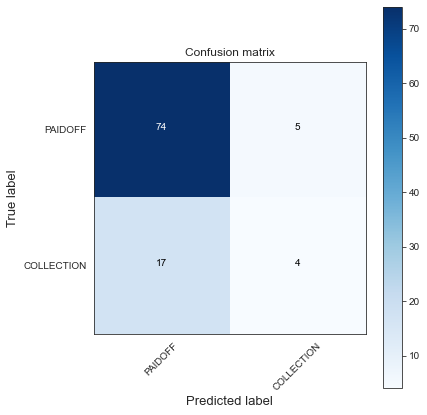

In [44]:
# Defining the function
## Note that this function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 13)
    plt.xlabel('Predicted label', fontsize = 13)
sns.set_style("white")

# Creating the confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_xgb2, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)
print (classification_report(y_test, yhat_xgb2))

# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plt.title("Confusion Matrix")
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False, title='Confusion matrix')

As shown, the model was more effective at correctly predicting loans that were paid off than those that were in collections. In other words, there was a higher percentage of incorrect predictions for loans that were in collections. 

### 4.3 Limitations and Future Directions<a class="anchor" id="chapter4.3"></a>

I outline several limitations and future directions below:

* The sample size was quite low. A more accurate classification model could be developed with a larger sample. 

* The final model's hyperparameters were tuned using Bayesian opimization with 150 evaluations. While this number was chosen for the sake of efficiency, better accuracy may be achieved by increasing the number of evaluations in addition to widening the range of potential values for each hyperparameter. 

* But more importantly than parameter-tuning, additional data collection (i.e., greater samples and additional features) and feature engineering is needed to enhace model effectiveness.

### Thank you!

Created by Young Hun Ji